In [9]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

### Preprocessing data

In [4]:
data_c = pd.read_parquet('./Local/2017_Clean/Combined.parquet')
data_f1 = pd.read_parquet('./Local/2017_Final/Combined_1.parquet')
data_f2 = pd.read_parquet('./Local/2017_Final/Combined_2.parquet')

datasets = {'Clean data': data_c, 'Final data 1': data_f1, 'Final data 2': data_f2}
matrices = {}

In [5]:
def preprocess_data(df):
    label_encoder = LabelEncoder()
    
    if 'Label' in df.columns:
        label_col = 'Label'
    elif ' Label' in df.columns:
        label_col = ' Label'
    else:
        raise ValueError("DataFrame does not contain a label column")
    
    df[label_col] = label_encoder.fit_transform(df[label_col])
    
    X = df.drop(label_col, axis=1)
    y = df[label_col]

    return X, y

processed_datasets = {name: preprocess_data(df) for name, df in datasets.items()}

### Running Logistic Regression for each dataset

In [7]:
for name, (X, y) in processed_datasets.items():
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    log_reg = LogisticRegression(random_state=0, max_iter=1000)
    log_reg.fit(X_train_scaled, y_train)

    y_pred_train = log_reg.predict(X_train_scaled)
    y_pred_test = log_reg.predict(X_test_scaled)
    
    print(f'--- {name} ---')
    print('Training Accuracy : ', metrics.accuracy_score(y_train, y_pred_train)*100)
    print('Validation Accuracy : ', metrics.accuracy_score(y_test, y_pred_test)*100)
    
    class_labels = y.unique()
    class_labels_str = [str(label) for label in class_labels]
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred_test, target_names=class_labels_str, zero_division=0))
    print('\n')

    cm = metrics.confusion_matrix(y_test, y_pred_test)
    matrices[name] = cm

--- Clean data ---
Training Accuracy :  97.87742358044655
Validation Accuracy :  97.9075968654767
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    429322
           2       0.91      0.02      0.05       408
          10       1.00      0.98      0.99     25511
           1       0.96      0.87      0.92      2025
           9       1.00      0.95      0.97     34698
          12       0.85      0.85      0.85      1017
          14       0.98      0.91      0.94      1113
          13       0.99      0.99      0.99      1182
           7       0.80      1.00      0.89         4
          11       0.67      0.29      0.40         7
           6       0.74      0.99      0.85     18185
           5       0.99      0.92      0.95       638
           4       0.00      0.00      0.00       289
           3       0.00      0.00      0.00         3
           8       0.00      0.00      0.00       126

    accuracy 

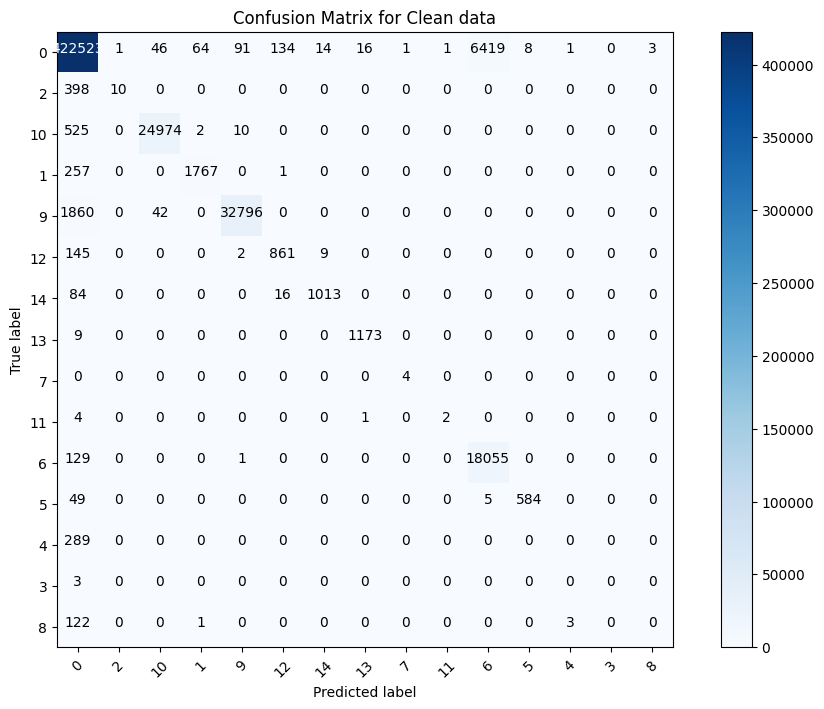

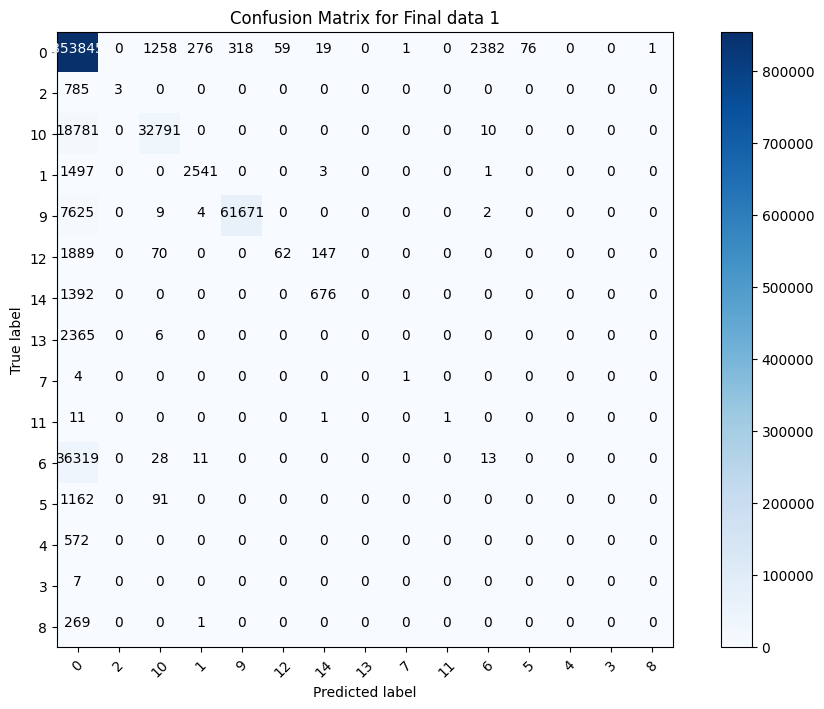

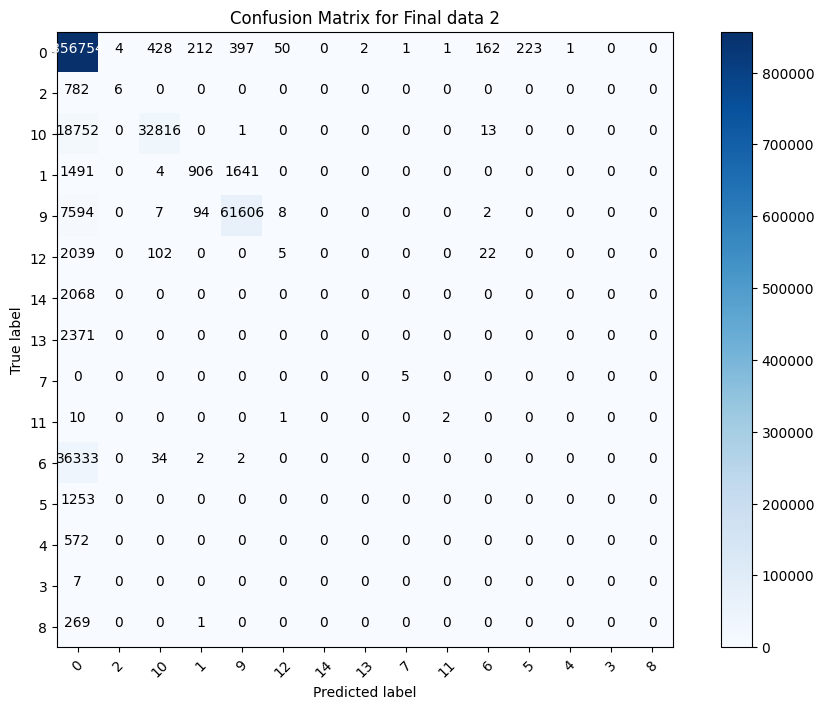

In [10]:
for name, matrix in matrices.items():
    plt.figure(figsize=(10, 7))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_labels_str))
    plt.xticks(tick_marks, class_labels_str, rotation=45)
    plt.yticks(tick_marks, class_labels_str)

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()